In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import torch
from torch import nn
import torchvision
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import os
import shutil

from torchinfo import summary
import torch.utils.tensorboard as tb

import models_pheno
import models_decode
import models_breed
import mnist
import neuroevolution
import coevolve_ne
import ordinary_ne

torch.manual_seed(10);
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
run_idx = 0

In [8]:
# import tempfile
# tb_log_dir = tempfile.mkdtemp()
user = os.getlogin()
# tb_log_dir = os.path.join(cp.data_dir, 'tensorboard/', user)
tb_log_dir = f'/tmp/tensorboard/{user}'
# print(tb_log_dir)
    

In [9]:
logger = tb.SummaryWriter(tb_log_dir, flush_secs=5)

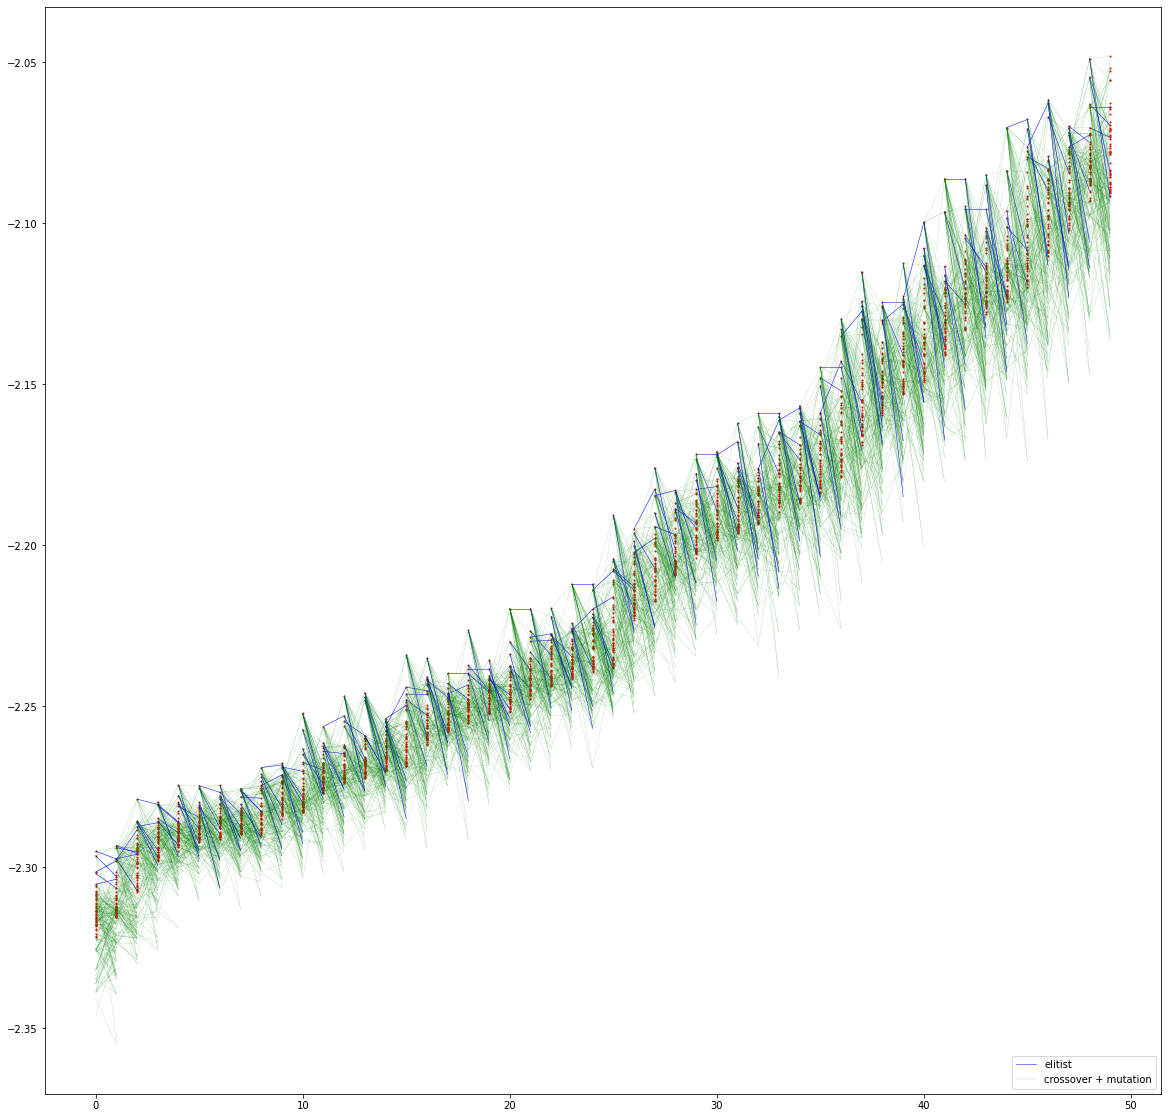

In [85]:
plt.figure(figsize=(20,20))
for gen_idx in range(50):
#     pop = torch.load(os.path.join(logger.log_dir, f'pop_gen_{gen_idx:05d}'))
    fitnesses = torch.load(os.path.join(logger.log_dir, f'fitnesses_gen_{gen_idx:05d}'))
#     fitnesses = np.arange(100)[::-1]
    plt.scatter(np.full_like(fitnesses, gen_idx)[:50], fitnesses[:50], c='r', s=1)
    if gen_idx>0:
        fitnesses_prev = torch.load(os.path.join(logger.log_dir, f'fitnesses_gen_{gen_idx-1:05d}'))
#         fitnesses_prev = np.arange(100)[::-1]
        parents_idxs = torch.load(os.path.join(logger.log_dir, f'parent_idxs_gen_{gen_idx:05d}'))
        for i, p_idx in enumerate(parents_idxs):
            if p_idx.size==1:
                pass
                clone = plt.plot([gen_idx, gen_idx-1], [fitnesses[i], fitnesses_prev[p_idx]], c='b', linewidth=0.5)
            else:
                pass
                cross = plt.plot([gen_idx-1, gen_idx, gen_idx-1], 
                                 [fitnesses_prev[p_idx[0]], fitnesses[i], fitnesses_prev[p_idx[1]]], c='g', linewidth=0.1)
plt.legend([clone[0], cross[0]], ['elitist', 'crossover + mutation'], loc='lower right')
            
